# Cycle Consistent Adversarial Networks (CycleGAN)

#### Same as Pix2Pix with an extra loss function (cycle consistency loss) and unlike paired target image, data is unpaired. Improves domains ncluding - neural style transfer, season transfer, time transfer, etc.

# Importing  the libraries

In [1]:
# Using pretrained Pix2Pix generator and discriminator
!pip install -q git+https://github.com/tensorflow/examples.git

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

tfds.disable_progress_bar()
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()[3]

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15701463552
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1510051619431410879
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"

In [4]:
#gpu_options = tf.compat.v1.GPUOptions(allow_growth=True)
#session = tf.compat.v1.InteractiveSession(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset
#### Image preprocessing is exactly the same as Pix2Pix

In [6]:
dataset, _ = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

train_horses, train_zebras = dataset['trainA'], dataset['trainB']
test_horses, test_zebras = dataset['testA'], dataset['testB']

In [7]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1      # compulsory because of instance normalization (not batch normalization)
IMAGE_SHAPE = (256, 256, 3)
RESIZE_SHAPE = (286, 286, 3)

In [8]:
def normalize(image):
    image = (tf.cast(image, tf.float32) - 127.5) / 127.5
    return image

@tf.function
def resize(image, height=IMAGE_SHAPE[0], width=IMAGE_SHAPE[1]):
    image = tf.image.resize(image, [height, width],
                            method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return image

@tf.function
def random_crop(image):
    cropped_image = tf.image.random_crop(
          image, size=list(IMAGE_SHAPE))

    return cropped_image

@tf.function
def preprocess(image):
    image = resize(image, RESIZE_SHAPE[0], RESIZE_SHAPE[1])
    image = random_crop(image)
    
    image = tf.image.random_flip_left_right(image)
    
    return image

In [9]:
def preprocess_image_train(image, label):
    image = preprocess(image)
    image = normalize(image)
    return image

def preprocess_image_test(image, label):
    image = normalize(image)
    return image

In [10]:
train_horses = train_horses.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_zebras = train_zebras.map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_horses = test_horses.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_zebras = test_zebras.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [11]:
sample_horse = next(iter(train_horses))
sample_zebra = next(iter(train_zebras))

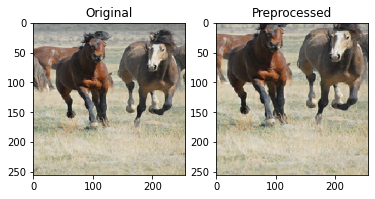

In [12]:
plt.subplot(121)
plt.title('Original')
plt.imshow(sample_horse[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Preprocessed')
plt.imshow(preprocess(sample_horse[0]) * 0.5 + 0.5)

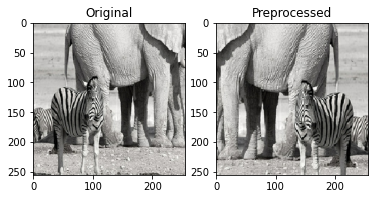

In [13]:
plt.subplot(121)
plt.title('Original')
plt.imshow(sample_zebra[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Preprocessed')
plt.imshow(preprocess(sample_zebra[0]) * 0.5 + 0.5)

# Reuse Pix2Pix models
#### There are 2 generators and 2 discriminators, trying to do opposite transformations
#### Generator G transforms from domain X -> Y, and F from Y -> X
#### Discriminator D_X differentiates X and F(Y) and D_Y differentiates Y and G(X)

In [14]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

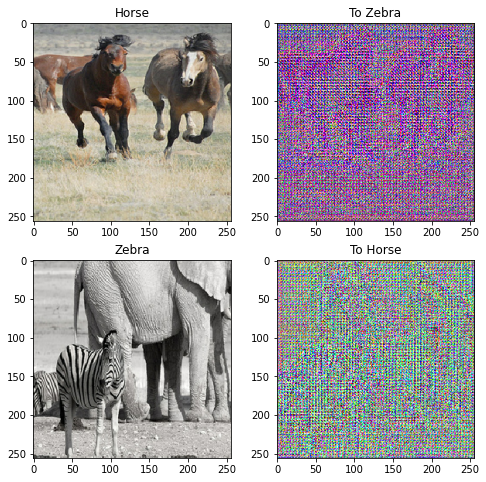

In [15]:
to_zebra = generator_g(sample_horse)
to_horse = generator_f(sample_zebra)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_horse, to_zebra, sample_zebra, to_horse]
title = ['Horse', 'To Zebra', 'Zebra', 'To Horse']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    if i % 2 == 0:
        plt.imshow(imgs[i][0] * 0.5 + 0.5)
    else:
        plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

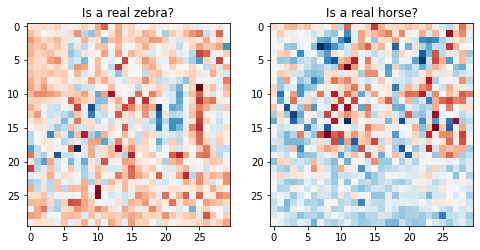

In [16]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is a real zebra?')
plt.imshow(discriminator_y(sample_zebra)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real horse?')
plt.imshow(discriminator_x(sample_horse)[0, ..., -1], cmap='RdBu_r')

plt.show()

In [17]:
LAMBDA = 10
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def generator_loss(generated_output):
    return binary_cross_entropy(tf.ones_like(generated_output), generated_output)

def discriminator_loss(real_output, generated_output):
    real_loss = binary_cross_entropy(tf.ones_like(real_output), real_output)
    generated_loss = binary_cross_entropy(tf.zeros_like(generated_output), generated_output)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

In [19]:
def cycle_loss(real_image, cycled_image):
    # l1 loss of pix2pix
    cycle_loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return LAMBDA * cycle_loss

def identity_loss(real_image, same_image):
    identity_loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * identity_loss

# Optimizers

In [20]:
generator_g_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

generator_f_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(0.0002, beta_1=0.5)

# Training

In [21]:
checkpoint_path = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_path, "ckpt")
ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

In [22]:
def generate_images(model, input_image):
    prediction = model(input_image, training=True)
    plt.figure(figsize=(15, 15))

    display_list = [input_image[0], prediction[0]]
    title = ['Input', 'Prediction']

    for i in range(2):
        plt.subplot(1, 2, i + 1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)     # images between 0 and 1
        
    plt.show()

In [23]:
@tf.function
def train_step(real_x, real_y):
    # persistent = True because the tape is used more than once
    with tf.GradientTape(persistent=True) as tape:
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_g(real_y, training=True)
        cycled_y = generator_f(fake_x, training=True)

        # for identity loss (make sure that original image is preserved, better training)
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        # total_gen_loss = adversarial_loss + cycle_loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Gradients
    generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

    generator_g_optimizer.apply_gradients(zip(generator_g_gradients,
                                            generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients,
                                            generator_f.trainable_variables))
                                                                                   
    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

    

In [24]:
def train(train_horses, train_zebras, epochs):
    for epoch in range(epochs):
        start = time.time()
        n = 0
        for (image_x, image_y) in zip(train_horses, train_zebras):
            train_step(image_x, image_y)
            if n % 10 == 0:
                print('.', end='')      # loading
            n += 1

        clear_output(wait=True)

        generate_images(generator_g, sample_horse)

        if (epoch + 1) % 10 == 0:
            ckpt.save(file_prefix=checkpoint_prefix)

        generator_g.save('/content/drive/My Drive/Colab Notebooks/models/cyclegan-generator-horse-to-zebra.h5')
        generator_f.save('/content/drive/My Drive/Colab Notebooks/models/cyclegan-generator-zebra-to-horse.h5')

        discriminator_x.save('/content/drive/My Drive/Colab Notebooks/models/cyclegan-discriminator-horse-to-zebra.h5')
        discriminator_y.save('/content/drive/My Drive/Colab Notebooks/models/cyclegan-discriminator-zebra-to-horse.h5')

        print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

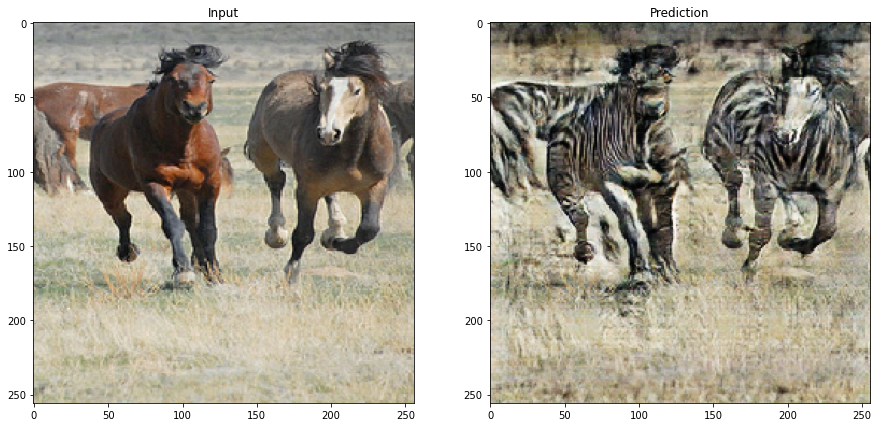

Time taken for epoch 92 is 250.17459511756897 sec

....................

In [ ]:
EPOCHS = 100
train(train_horses, train_zebras, EPOCHS)

In [ ]:
generator_g.save('/content/drive/My Drive/Colab Notebooks/models/cyclegan-horse-to-zebra.h5')
generator_f.save('/content/drive/My Drive/Colab Notebooks/models/cyclegan-zebra-to-horse.h5')